In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import os
import time

In [2]:
#present the current directory
print(os.getcwd())

/Users/shunarai/Desktop/research/researches/Doing/CMB-lensing_gravity/work/cals/goldrush_act_PR4/conf_space_measurements


In [3]:
# reading a map
def get_map(path, nside):
    map = hp.read_map(path)
    map = hp.ud_grade(map,nside_out=nside)
    map[np.isnan(map)==True]=0.
    return map

#reading a weight
def get_weight(path,nside):
    map = hp.read_map(path)
    weight = np.zeros(hp.nside2npix(hp.get_nside(map)))
    weight[map>0.] = 1.
    weight = hp.ud_grade(weight,nside_out=nside)
    weight[weight>0.] = 1.
    return weight

# mean subtraction
def get_map_zero_mean(map, weight):
    norm = sum(weight*map)/sum(weight)
    map_zero_mean = weight*map/norm - weight
    return map_zero_mean

#map rotator
def change_coord(m, coord):

    # Basic HEALPix parameters                                                            
    npix = m.shape[-1]
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))

    # Select the coordinate transformation                                                
    rot = hp.Rotator(coord=reversed(coord))

    # Convert the coordinates                                                             
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)

    return m[..., new_pix]

#corr. calculator
def get_twopt_corr(theta_bins, map1, map2, weight, nside):
    pixel_indices = np.where(weight>0.)[0]
    
    delta1 = get_map_zero_mean(map1,weight)
    delta2 = get_map_zero_mean(map2,weight)
    
    n_points = len(pixel_indices)
    pixel_counts = np.zeros(nbins)
    correlation_counts = np.zeros(nbins)
    for i in range(n_points):
        pixel_center = pixel_indices[i]
        neighbors = hp.query_disc(nside, hp.pix2vec(nside, pixel_center), np.pi/90.)  # Query the disc around the current pixel
        for neighbor in neighbors:
            sep = hp.rotator.angdist(hp.pix2ang(nside, pixel_center), hp.pix2ang(nside, neighbor))  # Calculate angular separation
            bin_index = np.searchsorted(theta_bins, sep)
            pixel_counts[bin_index - 1] += 1
            
            if weight[neighbor]==1. :
                correlation_counts[bin_index - 1] += delta1[pixel_center]*delta2[neighbor]  # Increment the count in the corresponding bin

    # Normalize the correlation function
    print(pixel_counts)
    print(correlation_counts)
    # Normalize the correlation function
    correlation_function = correlation_counts/pixel_counts
    
    return correlation_function

In [4]:
#Healpixconfig.
nside = 256
npix = hp.nside2npix(nside)
theta_pix = np.sqrt(hp.nside2pixarea(nside,degrees=True))
print(theta_pix)

# Angular binning for correlation function
nbins = 20
theta_bins = np.linspace(theta_pix*np.pi/180, np.pi/90., nbins + 1)
print(theta_bins)

0.2290324274544937
[0.00399737 0.00554283 0.00708829 0.00863375 0.01017921 0.01172467
 0.01327013 0.0148156  0.01636106 0.01790652 0.01945198 0.02099744
 0.0225429  0.02408836 0.02563382 0.02717928 0.02872474 0.0302702
 0.03181566 0.03336112 0.03490659]


In [5]:
# get PR4 CMB kappa map
klm = hp.read_alm('../../../data/planckPR4/PR4_variations/PR42018like_klm_dat_MV.fits')
klm_mean = hp.read_alm('../../../data/planckPR4/PR4_variations/PR42018like_klm_mf_MV.fits')
kmap = hp.alm2map(klm,nside=nside)
kmap_mean = hp.alm2map(klm_mean,nside=nside)
kmap_0 = hp.read_map('../../../data/planckPR4/PR4_variations/map.fits')
kmap_0 = hp.ud_grade(kmap_0,nside_out=nside)
kmask = hp.read_map('../../../data/planckPR4/PR4_variations/mask.fits')
kmask=hp.ud_grade(kmask,nside_out=nside)

In [6]:
#Galactic to Celestrial
#kmap = change_coord(kmap,['G','C'])
#kmap_mean = change_coord(kmap_mean,['G','C'])
#kmask = change_coord(kmask,['G','C'])

In [7]:
#test mean
print(np.mean(kmap),np.mean(kmap_mean))
print(np.mean(change_coord(kmap,['G','C'])),np.mean(change_coord(kmap_mean,['G','C'])))

-0.0016048614849498773 6.151113813197958e-05
-0.0014942588989796653 8.509591577700316e-05


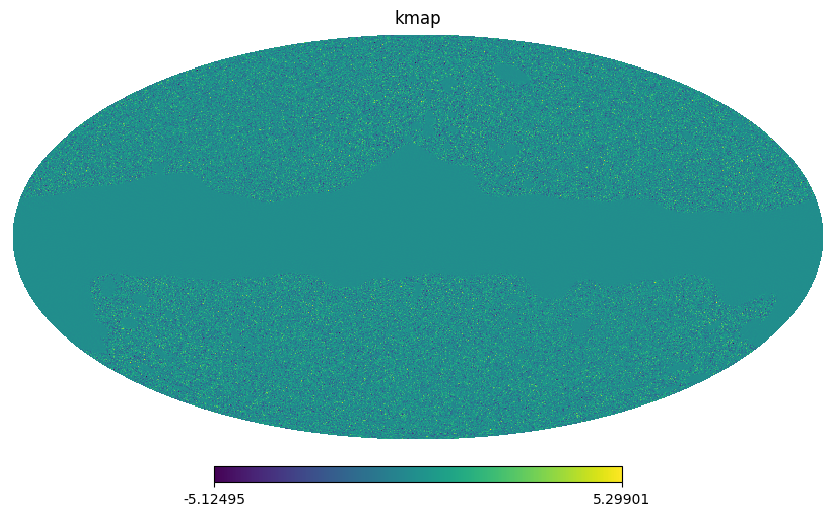

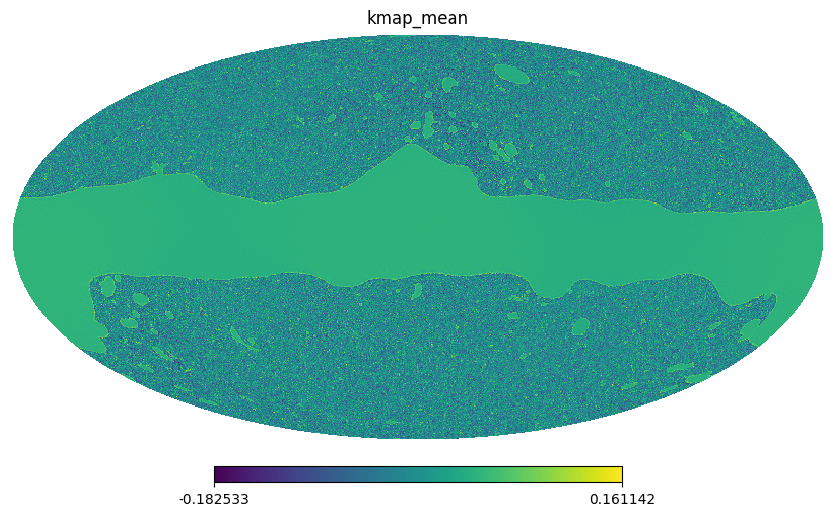

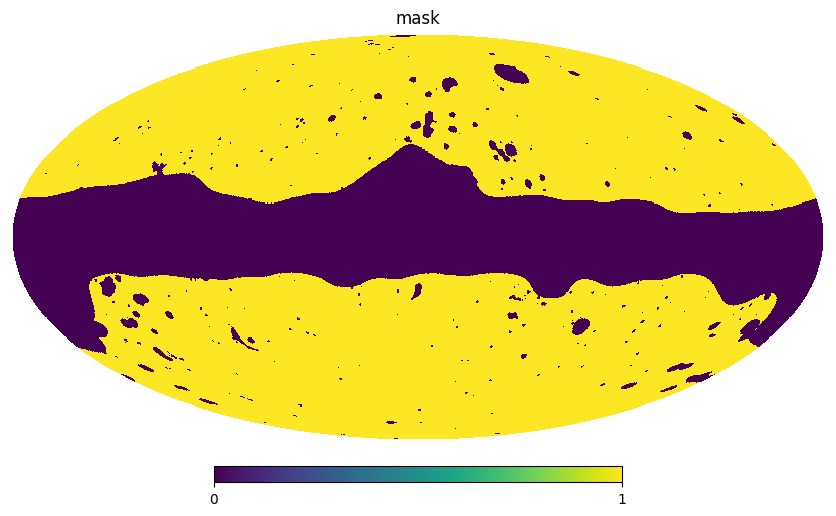

In [8]:
#visualisation
hp.mollview(kmap,title='kmap')
hp.mollview(kmap_mean,title='kmap_mean')
hp.mollview(kmask,title='mask')
plt.show()

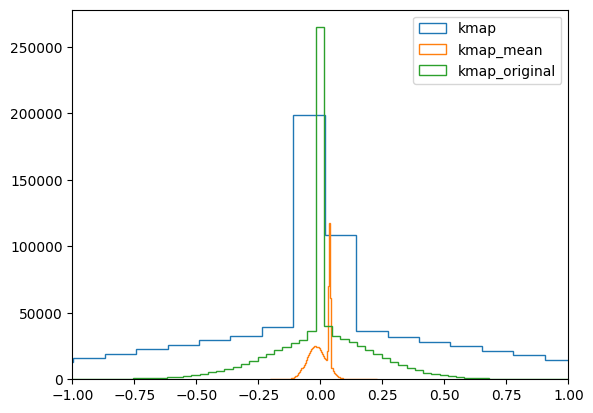

In [9]:
#histogram
plt.hist(kmap,bins=100, histtype='step',label='kmap')
plt.hist(kmap_mean,bins=100,histtype='step',label='kmap_mean')
plt.hist(kmap_0,bins=100, histtype='step',label='kmap_original')
plt.xlim([-1., 1.])
plt.legend()
plt.show()

In [10]:
# get gal maps
root = '../../../fits/HSC_ACT/goldrush'
maps = {'LBGs': get_map(root+'/cmap_SigmaClippedAround_SNcutted_gri_W_W02_i_fluxcut25p5_nside%d.fits'%nside,nside),
            'random': hp.ud_grade(get_map(root+'/cmap_SigmaClippedAround_random_W_W02_nside2048.fits',2048),nside),
             'stars': get_map(root+'/cmap_SigmaClippedAround_SNcutted_gri_W_W02_i_fluxcut25p5_stars_nside%d.fits'%nside,nside),
             'g_fluxsigma2': get_map(root+'/cmap_g_fluxsigma2_sky_W_W02_nside%d.fits'%nside,nside),
             'r_fluxsigma2': get_map(root+'/cmap_r_fluxsigma2_sky_W_W02_nside%d.fits'%nside,nside),
             'i_fluxsigma2': get_map(root+'/cmap_i_fluxsigma2_sky_W_W02_nside%d.fits'%nside,nside),
             'i_sdss_seeing': get_map(root+'/cmap_i_sdss_FWHM_nside%d.fits'%nside,nside)
             }
#get weight
weight = get_weight(root+'/cmap_SigmaClippedAround_SNcutted_gri_W_W02_i_fluxcut25p5_nside2048.fits',nside)
map_names = list(maps.keys())
print(map_names)

['LBGs', 'random', 'stars', 'g_fluxsigma2', 'r_fluxsigma2', 'i_fluxsigma2', 'i_sdss_seeing']


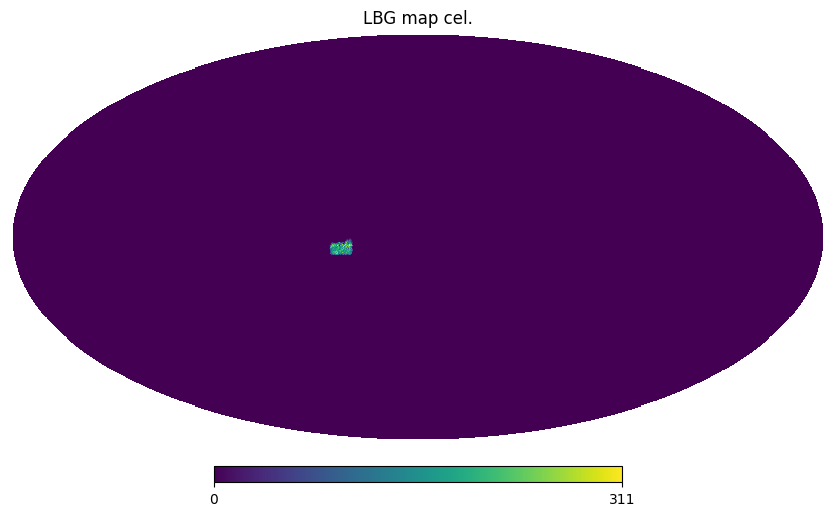

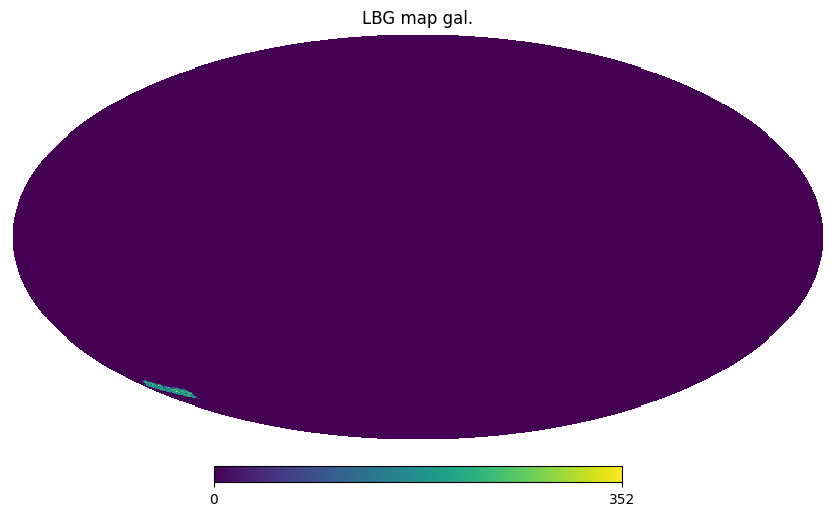

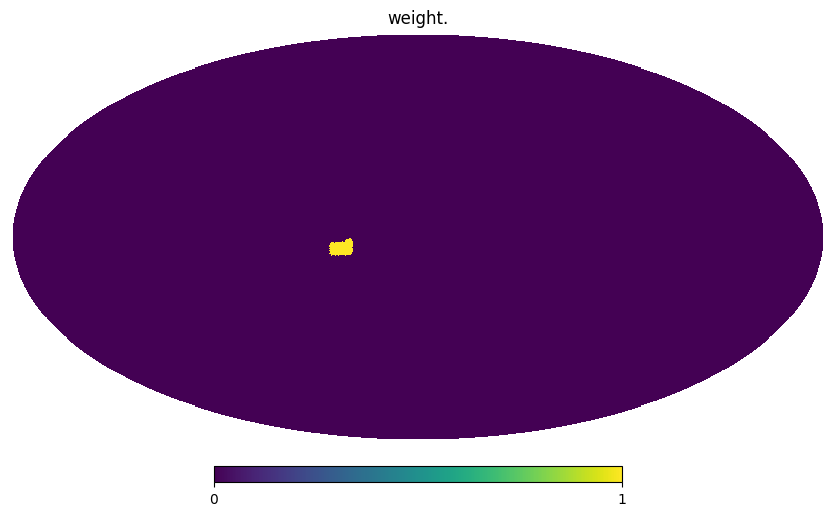

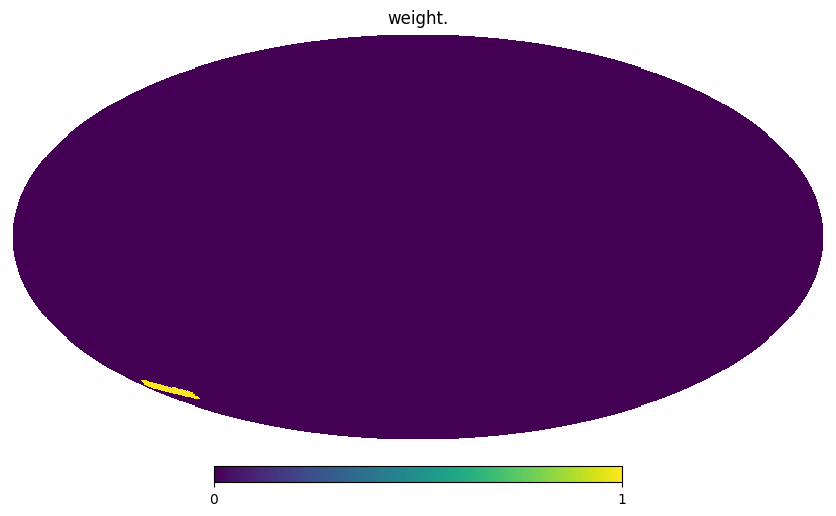

In [11]:
# visualisation of the LBG map
#visualisation
hp.mollview(maps['LBGs'],title='LBG map cel.')
hp.mollview(change_coord(maps['LBGs'],['C','G']),title='LBG map gal.')
hp.mollview(weight,title='weight.')
hp.mollview(kmask*change_coord(weight,['C','G']),title='weight.')
plt.show()

[ 6150.  2050.  8200.  4100.  2050. 10318.  8132. 14350.  8200. 10250.
 14316. 12334. 12300. 22550. 10250. 20500. 16166. 16634. 24600. 21525.]
[ 3409.02852846  1068.97277524  3019.40424254  1678.52350427
   552.13774317  3050.93457114  1826.25965126  2784.55292153
  1207.37227259  1624.40046127   616.86139907  1568.58021294
    85.45272016  1105.43987878  -406.43254689   641.96351705
 -1836.42185528   469.58131196 -1804.83119816   736.95583876]


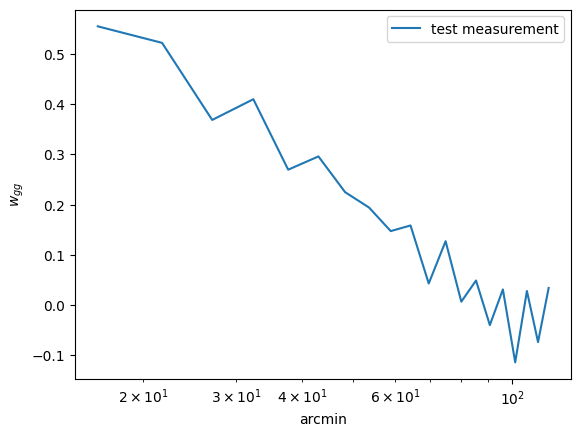

In [12]:
# test xcorr. measurement gg acorr. at W02
gmap = maps['LBGs']-maps['random']
w_test = get_twopt_corr(theta_bins, gmap, gmap, weight, nside)
theta_mid = 0.5 * (theta_bins[1:] + theta_bins[:-1])
plt.plot(np.degrees(theta_mid)*60., w_test, label = 'test measurement')
plt.xscale('log')
plt.xlabel('arcmin')
plt.ylabel(r'$w_{gg}$')
plt.legend()
plt.show()

[ 6150.  2050.  8200.  4100.  2050. 10318.  8132. 14350.  8200. 10250.
 14316. 12334. 12300. 22550. 10250. 20500. 16166. 16634. 24600. 21525.]
[  723.81392218 -1107.53182976 -1752.31287299   532.77084941
  1460.6395056   4871.49536986  -327.07920392 -1497.59842638
 -2822.11882815  1041.82602337 -1401.23956154 -4036.78357179
  2129.36583308  8148.94659884  2507.82596538  -312.34019077
 -1054.05553942  1790.29160957 -2249.7421755  -1935.16559922]


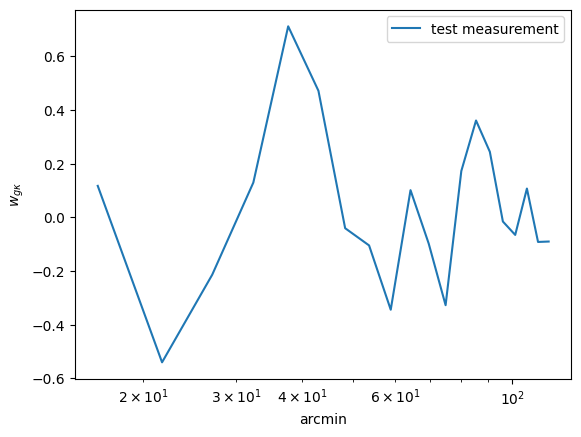

In [13]:
# test xcorr. measurement kg xcorr. at W02
w_test = get_twopt_corr(theta_bins, gmap, kmap, weight, nside)
theta_mid = 0.5 * (theta_bins[1:] + theta_bins[:-1])
plt.plot(np.degrees(theta_mid*60.), w_test, label = 'test measurement')
plt.xscale('log')
plt.xlabel('arcmin')
plt.ylabel(r'$w_{g\kappa}$')
plt.legend()
plt.show()

In [14]:
'''
# generating corr. keys

def twopt_iter():
    i = 0
    for i1, nm1 in enumerate(map_names):
        for i2, nm2 in enumerate(map_names):
            # Skip repeated 
            if i2 < i1:
                continue
            twopt_name = f'{nm1}_vs_{nm2}'
            yield i, i1, i2, nm1, nm2, twopt_name
            i += 1
'''

"\n# generating corr. keys\n\ndef twopt_iter():\n    i = 0\n    for i1, nm1 in enumerate(map_names):\n        for i2, nm2 in enumerate(map_names):\n            # Skip repeated \n            if i2 < i1:\n                continue\n            twopt_name = f'{nm1}_vs_{nm2}'\n            yield i, i1, i2, nm1, nm2, twopt_name\n            i += 1\n"

In [15]:
'''
w ={}
for i, _, _, nm1, nm2, twopt_name in twopt_iter():
    print(twopt_name)
    m1 = maps[nm1]
    m2 = maps[nm2]
    start = time.perf_counter()
    print('computing %s corr. func. '%twopt_name)
    w[twopt_name] = get_twopt_corr(theta_bins, m1,m2, weight, nside)
    end = time.perf_counter()
    print('computation finshed in %e sec. '%(end-start))
    theta_mid = 0.5 * (theta_bins[1:] + theta_bins[:-1])
    plt.plot(np.degrees(theta_mid), w[twopt_name], label = twopt_name)

# Plot the correlation function
plt.axvline(theta_pix)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Angular Separation (degrees)')
plt.ylabel('Correlation Function')
plt.title('Angular Two-Point Correlation Function')
plt.legend()
plt.show()
'''

"\nw ={}\nfor i, _, _, nm1, nm2, twopt_name in twopt_iter():\n    print(twopt_name)\n    m1 = maps[nm1]\n    m2 = maps[nm2]\n    start = time.perf_counter()\n    print('computing %s corr. func. '%twopt_name)\n    w[twopt_name] = get_twopt_corr(theta_bins, m1,m2, weight, nside)\n    end = time.perf_counter()\n    print('computation finshed in %e sec. '%(end-start))\n    theta_mid = 0.5 * (theta_bins[1:] + theta_bins[:-1])\n    plt.plot(np.degrees(theta_mid), w[twopt_name], label = twopt_name)\n\n# Plot the correlation function\nplt.axvline(theta_pix)\nplt.xscale('log')\n#plt.yscale('log')\nplt.xlabel('Angular Separation (degrees)')\nplt.ylabel('Correlation Function')\nplt.title('Angular Two-Point Correlation Function')\nplt.legend()\nplt.show()\n"

In [16]:
'''
# cross corr. with LBGs
plt.axvline(theta_pix, color='black', label='pixel size with nside = %d'%nside)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Angular Separation (degrees)')
plt.ylabel('Correlation Function')
theta_mid = 0.5 * (theta_bins[1:] + theta_bins[:-1])
plt.plot(np.degrees(theta_mid), w['LBGs_vs_stars'], label = 'LBGs_vs_stars')
plt.plot(np.degrees(theta_mid), w['LBGs_vs_g_fluxsigma2'], label = 'LBGs_vs_g_fluxsigma2')
plt.plot(np.degrees(theta_mid), w['LBGs_vs_r_fluxsigma2'], label = 'LBGs_vs_r_fluxsigma2')
plt.plot(np.degrees(theta_mid), w['LBGs_vs_i_fluxsigma2'], label = 'LBGs_vs_i_fluxsigma2')
plt.plot(np.degrees(theta_mid), w['LBGs_vs_i_sdss_seeing'], label = 'LBGs_vs_i_sdss_seeing')
plt.title('Angular Two-Point Correlation Function')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)
plt.show()
'''

"\n# cross corr. with LBGs\nplt.axvline(theta_pix, color='black', label='pixel size with nside = %d'%nside)\nplt.xscale('log')\n#plt.yscale('log')\nplt.xlabel('Angular Separation (degrees)')\nplt.ylabel('Correlation Function')\ntheta_mid = 0.5 * (theta_bins[1:] + theta_bins[:-1])\nplt.plot(np.degrees(theta_mid), w['LBGs_vs_stars'], label = 'LBGs_vs_stars')\nplt.plot(np.degrees(theta_mid), w['LBGs_vs_g_fluxsigma2'], label = 'LBGs_vs_g_fluxsigma2')\nplt.plot(np.degrees(theta_mid), w['LBGs_vs_r_fluxsigma2'], label = 'LBGs_vs_r_fluxsigma2')\nplt.plot(np.degrees(theta_mid), w['LBGs_vs_i_fluxsigma2'], label = 'LBGs_vs_i_fluxsigma2')\nplt.plot(np.degrees(theta_mid), w['LBGs_vs_i_sdss_seeing'], label = 'LBGs_vs_i_sdss_seeing')\nplt.title('Angular Two-Point Correlation Function')\nplt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)\nplt.show()\n"